## Task 1

In [30]:
import os
import glob
import json

from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

root_dir = "./TestDataSet"
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

with open(os.path.join(root_dir, "labels_list.json"), "r") as f:
    idx_to_label = json.load(f)

image_label_list = []
for imagenet_idx, wnid in enumerate(sorted(os.listdir(root_dir))):
    full_path = os.path.join(root_dir, wnid)
    if not os.path.isdir(full_path) or wnid.startswith("."):
        continue
    image_files = glob.glob(os.path.join(full_path, "*.JPEG"))
    for img_path in image_files:
        image_label_list.append((img_path, imagenet_idx + 398))

In [31]:
class CustomImageNetDataset(Dataset):
    def __init__(self, image_label_list, transform=None):
        self.data = image_label_list
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [32]:
dataset = CustomImageNetDataset(image_label_list, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False)
print(len(dataset))
print(len(loader))

500
16


In [90]:
import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights='IMAGENET1K_V1')
model.to(device)
model.eval();

In [34]:
top1_total = 0
top5_total = 0
n_samples = 0

with torch.no_grad():
    for images, labels in tqdm(loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_preds = preds[:, 0]
        top5_correct = (preds == labels.view(-1, 1)).any(dim=1)

        top1_total += (top1_preds == labels).sum().item()
        top5_total += top5_correct.sum().item()
        n_samples += labels.size(0)

print(f"Top-1 Accuracy: {top1_total / n_samples:.4f}")
print(f"Top-5 Accuracy: {top5_total / n_samples:.4f}")

100%|██████████| 16/16 [00:00<00:00, 23.97it/s]

Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


## Task 2

In [59]:
import torch.nn.functional as F

def fgsm_attack(image, label, model, epsilon):
    image.requires_grad = True
    output = model(image)
    loss = F.cross_entropy(output, label)
    model.zero_grad()
    loss.backward()
    adv_image = image + epsilon * image.grad.data.sign()
    adv_image = torch.clamp(adv_image, 0, 1)
    return adv_image.detach()

In [66]:
adv_images = []
adv_labels = []

model.eval()
epsilon = 0.02

for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    for i in range(images.size(0)):
        img = images[i].unsqueeze(0)
        lbl = labels[i].unsqueeze(0).to(device)
        adv = fgsm_attack(img, lbl, model, epsilon)
        adv_images.append(adv.squeeze(0).cpu())
        adv_labels.append(lbl.squeeze(0).cpu())

100%|██████████| 16/16 [00:05<00:00,  3.07it/s]


In [67]:
import torch.utils.data as data

class AdversarialDataset(data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

adv_dataset = AdversarialDataset(adv_images, adv_labels)
adv_loader = DataLoader(adv_dataset, batch_size=32, shuffle=False)

In [68]:
top1_total = 0
top5_total = 0
n_samples = 0

model.eval()

with torch.no_grad():
    for images, labels in tqdm(adv_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_preds = preds[:, 0]
        top5_correct = (preds == labels.view(-1, 1)).any(dim=1)

        top1_total += (top1_preds == labels).sum().item()
        top5_total += top5_correct.sum().item()
        n_samples += labels.size(0)
        
if n_samples > 0:
    print(f"FGSM Attack Top-1 Accuracy: {top1_total / n_samples:.4f}")
    print(f"FGSM Attack Top-5 Accuracy: {top5_total / n_samples:.4f}")
else:
    print("n_samples is 0 — check your DataLoader or attack generation.")

100%|██████████| 16/16 [00:00<00:00, 61.90it/s]

FGSM Attack Top-1 Accuracy: 0.2660
FGSM Attack Top-5 Accuracy: 0.5040


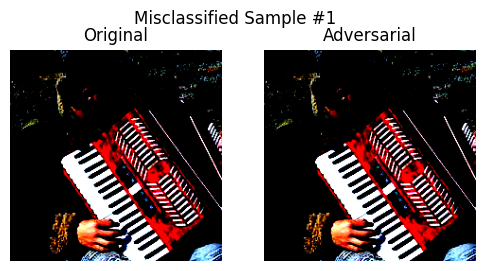

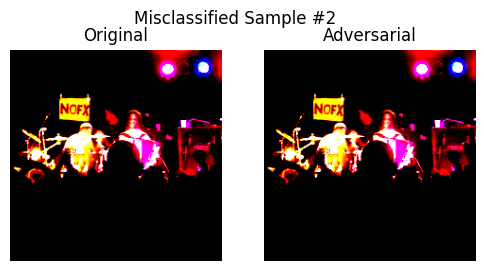

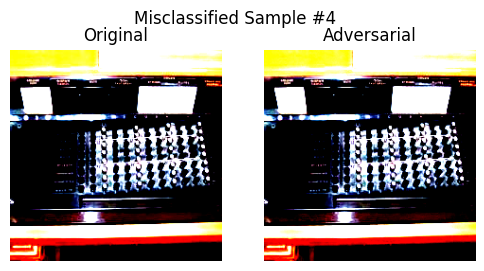

In [70]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

def tensor_to_numpy_img(tensor):
    tensor = tensor.detach().cpu()
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()

def show_comparison(orig_tensor, adv_tensor, idx=0):
    orig_img = tensor_to_numpy_img(orig_tensor)
    adv_img = tensor_to_numpy_img(adv_tensor)

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(orig_img)
    axs[0].set_title("Original")
    axs[1].imshow(adv_img)
    axs[1].set_title("Adversarial")
    for ax in axs:
        ax.axis('off')
    plt.suptitle(f"Misclassified Sample #{idx}")
    plt.show()

model.eval()
num_shown = 0

for i in range(len(adv_dataset)):
    adv_img, true_label = adv_dataset[i]
    input_tensor = adv_img.unsqueeze(0).to(device)
    true_label = true_label.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_label = output.argmax(dim=1).item()

    if pred_label != true_label.item():
        show_comparison(loader.dataset[i][0], adv_img, idx=i)
        num_shown += 1

    if num_shown >= 3:
        break

## Task 3

In [71]:
def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iters=10):
    ori_images = images.clone().detach()
    adv_images = ori_images.clone().detach()

    for _ in range(iters):
        adv_images.requires_grad = True
        outputs = model(adv_images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        adv_images = adv_images + alpha * adv_images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-epsilon, max=epsilon)
        adv_images = torch.clamp(ori_images + eta, 0, 1).detach()

    return adv_images

In [72]:
pgd_adv_images = []
pgd_adv_labels = []

model.eval()
epsilon = 0.02
alpha = 0.005
iters = 10

for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    adv = pgd_attack(model, images, labels, epsilon=epsilon, alpha=alpha, iters=iters)
    pgd_adv_images.extend(adv.cpu())
    pgd_adv_labels.extend(labels.cpu())

100%|██████████| 16/16 [00:07<00:00,  2.24it/s]


In [73]:
pgd_adv_dataset = AdversarialDataset(pgd_adv_images, pgd_adv_labels)
pgd_adv_loader = DataLoader(pgd_adv_dataset, batch_size=32, shuffle=False)

In [74]:
top1_total = 0
top5_total = 0
n_samples = 0

with torch.no_grad():
    for images, labels in tqdm(pgd_adv_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_preds = preds[:, 0]
        top5_correct = (preds == labels.view(-1, 1)).any(dim=1)

        top1_total += (top1_preds == labels).sum().item()
        top5_total += top5_correct.sum().item()
        n_samples += labels.size(0)

print(f"PGD Attack Top-1 Accuracy: {top1_total / n_samples:.4f}")
print(f"PGD Attack Top-5 Accuracy: {top5_total / n_samples:.4f}")

100%|██████████| 16/16 [00:00<00:00, 58.26it/s]

PGD Attack Top-1 Accuracy: 0.0040
PGD Attack Top-5 Accuracy: 0.0680


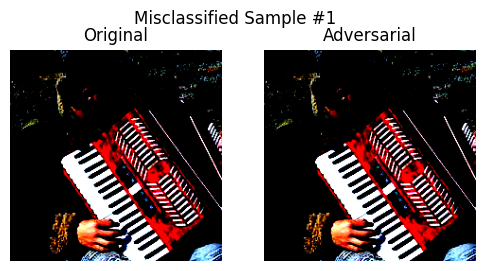

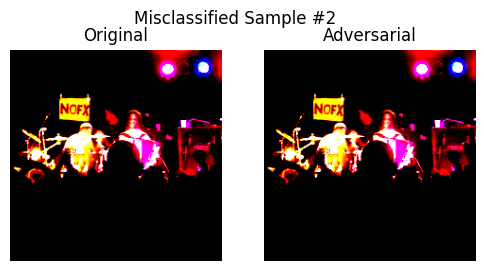

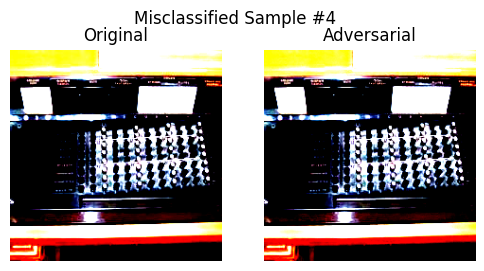

In [75]:
model.eval()
num_shown = 0

for i in range(len(pgd_adv_dataset)):
    adv_img, true_label = adv_dataset[i]
    input_tensor = adv_img.unsqueeze(0).to(device)
    true_label = true_label.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_label = output.argmax(dim=1).item()

    if pred_label != true_label.item():
        show_comparison(loader.dataset[i][0], adv_img, idx=i)
        num_shown += 1

    if num_shown >= 3:
        break

## Task 4

In [76]:
def patch_pgd_attack(model, images, labels, epsilon=0.3, alpha=0.01, iters=10, patch_size=32):
    adv_images = images.clone().detach()
    B, C, H, W = images.shape

    for i in range(B):
        x = torch.randint(0, W - patch_size, (1,)).item()
        y = torch.randint(0, H - patch_size, (1,)).item()

        patch = adv_images[i, :, y:y+patch_size, x:x+patch_size].clone().detach()

        for _ in range(iters):
            patch.requires_grad = True
            temp_image = adv_images[i].clone().detach()
            temp_image[:, y:y+patch_size, x:x+patch_size] = patch

            output = model(temp_image.unsqueeze(0))
            loss = F.cross_entropy(output, labels[i].unsqueeze(0))
            model.zero_grad()
            loss.backward()

            patch = patch + alpha * patch.grad.sign()
            patch = torch.clamp(patch, images[i, :, y:y+patch_size, x:x+patch_size] - epsilon,
                                         images[i, :, y:y+patch_size, x:x+patch_size] + epsilon)
            patch = torch.clamp(patch, 0, 1).detach()

        adv_images[i, :, y:y+patch_size, x:x+patch_size] = patch

    return adv_images

In [79]:
patch_adv_images = []
patch_adv_labels = []

epsilon = 0.5
alpha = 0.01
iters = 10
patch_size = 32

for images, labels in tqdm(loader):
    images, labels = images.to(device), labels.to(device)
    adv = patch_pgd_attack(model, images, labels, epsilon=epsilon, alpha=alpha, iters=iters, patch_size=patch_size)
    patch_adv_images.extend(adv.cpu())
    patch_adv_labels.extend(labels.cpu())

100%|██████████| 16/16 [00:47<00:00,  2.99s/it]


In [80]:
patch_adv_dataset = AdversarialDataset(patch_adv_images, patch_adv_labels)
patch_adv_loader = DataLoader(patch_adv_dataset, batch_size=32, shuffle=False)

top1_total = 0
top5_total = 0
n_samples = 0

with torch.no_grad():
    for images, labels in tqdm(patch_adv_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.topk(5, 1, True, True)

        top1_preds = preds[:, 0]
        top5_correct = (preds == labels.view(-1, 1)).any(dim=1)

        top1_total += (top1_preds == labels).sum().item()
        top5_total += top5_correct.sum().item()
        n_samples += labels.size(0)

print(f"Patch Attack Top-1 Accuracy: {top1_total / n_samples:.4f}")
print(f"Patch Attack Top-5 Accuracy: {top5_total / n_samples:.4f}")

100%|██████████| 16/16 [00:00<00:00, 60.76it/s]

Patch Attack Top-1 Accuracy: 0.6740
Patch Attack Top-5 Accuracy: 0.9060


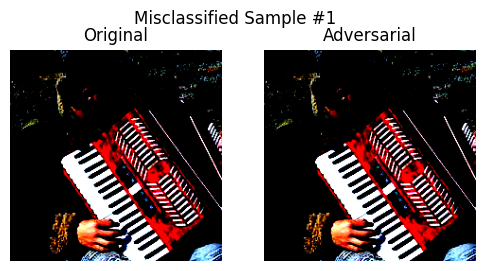

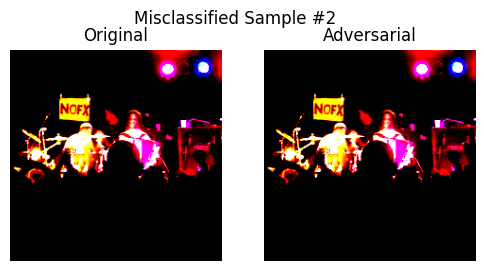

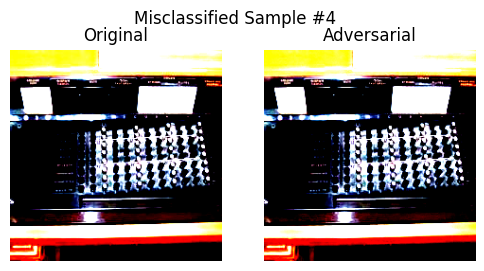

In [81]:
model.eval()
num_shown = 0

for i in range(len(patch_adv_dataset)):
    adv_img, true_label = adv_dataset[i]
    input_tensor = adv_img.unsqueeze(0).to(device)
    true_label = true_label.to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_label = output.argmax(dim=1).item()

    if pred_label != true_label.item():
        show_comparison(loader.dataset[i][0], adv_img, idx=i)
        num_shown += 1

    if num_shown >= 3:
        break

## Task 5

In [87]:
from torchvision.models import densenet121

transfer_model = densenet121(weights='IMAGENET1K_V1').to(device)
transfer_model.eval();

In [88]:
def evaluate_model(model, dataloader):
    top1_total = 0
    top5_total = 0
    n_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.topk(5, 1, True, True)

            top1_preds = preds[:, 0]
            top5_correct = (preds == labels.view(-1, 1)).any(dim=1)

            top1_total += (top1_preds == labels).sum().item()
            top5_total += top5_correct.sum().item()
            n_samples += labels.size(0)

    top1_acc = top1_total / n_samples
    top5_acc = top5_total / n_samples
    return top1_acc, top5_acc

In [91]:
print("Transfer to DenseNet-121")
acc_results = {}

acc_results["Original"] = evaluate_model(transfer_model, loader)
acc_results["FGSM"] = evaluate_model(transfer_model, adv_loader)
acc_results["PGD"] = evaluate_model(transfer_model, pgd_adv_loader)
acc_results["Patch"] = evaluate_model(transfer_model, patch_adv_loader)

for name, (top1, top5) in acc_results.items():
    print(f"{name} → Top-1: {top1:.4f}, Top-5: {top5:.4f}")

Transfer to DenseNet-121


100%|██████████| 16/16 [00:00<00:00, 37.16it/s]

Original → Top-1: 0.7460, Top-5: 0.9360
FGSM → Top-1: 0.4260, Top-5: 0.6620
PGD → Top-1: 0.3900, Top-5: 0.6360
Patch → Top-1: 0.7260, Top-5: 0.9240
